
# Predicting major shifts in international relations

Given data from an academically curated [The Correlates of War](http://www.correlatesofwar.org/data-sets) project that provides information on international relations from about 1820 to about 2007, <br>

<b>Can we predict major shifts in international relations, such as wars?</b>
> <b>More specifically, can we predict if a devastating war is highly likely to occur within the next five years?</b>

<b>Client:</b> international humanitarian nonprofits and/or governments who would be more prepared for major shifts in the world, and may be more informed in their efforts to act preemptively.


## Datasets used here:
* For historical world population data, I used [Worldometers](http://www.worldometers.info/world-population/world-population-by-year/) (last accessed July 19, 2018).
* Data on international wars (i.e. wars involving any number of independent states) comes from this [page](http://www.correlatesofwar.org/data-sets/COW-war) in The Correlates of War. The version of the dataset used is `4.0`. The data spans years 1823 to 2003.
* For diplomatic relations data, I accessed this [page](http://www.correlatesofwar.org/data-sets/diplomatic-exchange) on The Correlates of War website. The version of the dataset used is `2006v1`. The webpage also contains a comprehensive codebook, aka data dictionary for diplomatic relations data. The data spans years 1817 to 2005, with periodicity of 5 years for the most part.


## Other datasets to consider:
* The Correlates of War website has data on trade relations between 1870 and 2014. It would be interesting to see how patterns in trade relations correlate with wars.
* The same website has data on how different religions were represented in every country at different times. Are there any patterns there that may indicate an upcoming inter-state war?


## Deliverables to consider for final submission:

1. An interactive world map visualization that would show the shifts in how different countries were prone to war
1. An interactive timeline showing likelihood of a devastating war at different points in time, up to present day

***

## Data Wrangling

In [3]:
import pandas as pd
import numpy as np
import scipy.stats  as stats
import matplotlib.pyplot as plt
import warnings

In [10]:
warnings.filterwarnings("ignore", category=UserWarning)
import pandas_profiling as pdprofiling

The data I use here combines The Correlates of War data on wars, and Worldometers data on historical world population. This data wrangling and combining was done in a separate Jupyter Notebook, and is not included in this one. <br>

I interpolated world population data and combined it with war data, to estimate the ratio of deaths in battle versus world population. This will inform whether to consider a war devastating or not.

In [36]:
wars = pd.read_csv("data/batcasualties_per_war_v_worldpop.csv")

In [37]:
wars.head()

,WarNum,BatDeath,StartYear1,WorldPop
0,1,1000,1823,86956522
1,4,130000,1828,108695652
2,7,19283,1846,186956522
3,10,7527,1848,195652174
4,13,6000,1848,195652174


<b><i>Quick codebook</i></b> <br>

<b>`wars`:</b>

`WarNum`: uniquely identifies each war, numeric <br>
`BatDeath`: number of deaths in battle in a given war, numeric <br>
`StartYear1`: the year when the war started <br>
`WorldPop`: world population at the start of the war

### Let's see the distribution of values for: 
### `(war casualties for each war)/ (world population at the time)`

In [38]:
wars['casualtiesVWorldPop'] = wars['BatDeath']*1.0/wars['WorldPop']

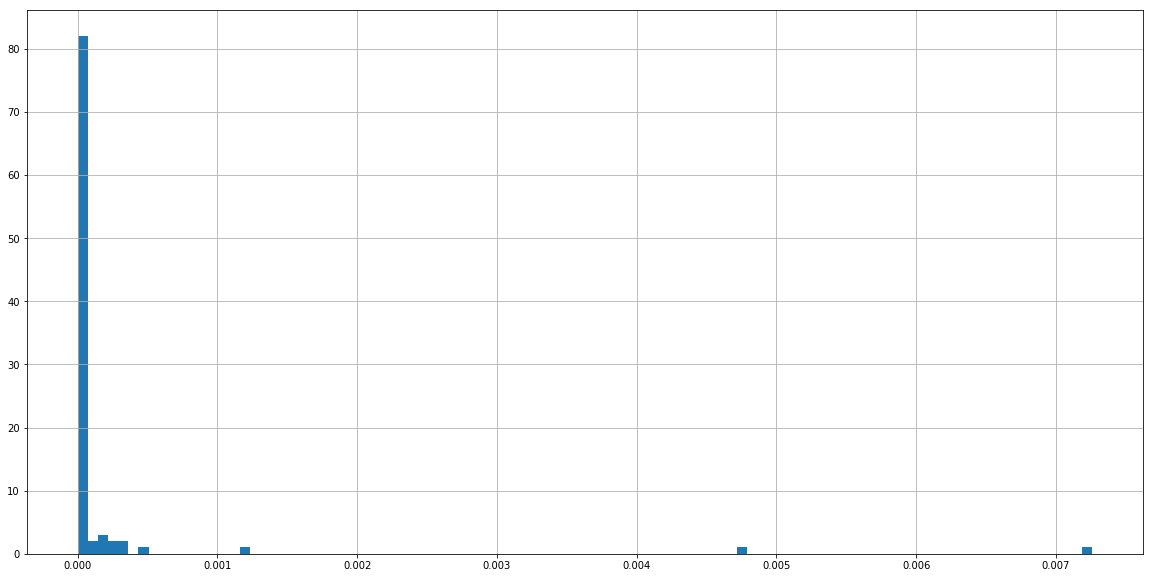

In [45]:
from matplotlib.pyplot import figure
fig = figure(figsize = (20, 10))
wars['casualtiesVWorldPop'].hist(bins = 100)
plt.show()

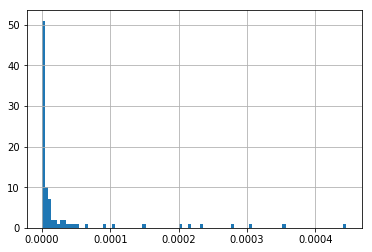

In [47]:
wars[wars['casualtiesVWorldPop']<0.001]['casualtiesVWorldPop'].hist(bins = 100)
plt.show()

Unfortunately, we do not have total deaths numbers for each war, that would include civilian casualties, so we will have to assume that these numbers are highly positively correlated with deaths in battle. <br>

<b> As we see from above, wars where 1 in every 10,000 living persons die, are quite rare. So let's take that as a definition of a devastating war: one, where more than 1 in every 10,000 living persons die in battle.</b>

In [375]:
(wars['casualtiesVWorldPop']>0.0001).sum()

12

There are 12 such wars that happened between 1823 and 2007.

In [385]:
wars['is_highDeath'] = (wars['casualtiesVWorldPop']>0.0001).astype(int)
wars.head()

,WarNum,BatDeath,StartYear1,WorldPop,casualtiesVWorldPop,is_highDeath
0,1,1000,1823,86956522,0.000011,0
1,4,130000,1828,108695652,0.001196,1
2,7,19283,1846,186956522,0.000103,1
3,10,7527,1848,195652174,0.000038,0
4,13,6000,1848,195652174,0.000031,0


In [386]:
wars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 6 columns):
WarNum                 95 non-null int64
BatDeath               95 non-null int64
StartYear1             95 non-null int64
WorldPop               95 non-null int64
casualtiesVWorldPop    95 non-null float64
is_highDeath           95 non-null int32
dtypes: float64(1), int32(1), int64(4)
memory usage: 4.2 KB


### Now let's read in the full dataset on wars as obtained from The Correlates of War website.

In [387]:
wars_w_countries_etc = pd.read_csv('data/Inter-StateWarData_v4.0.csv')

In [388]:
wars_w_countries_etc.head()

,WarNum,WarName,WarType,ccode,StateName,Side,StartMonth1,StartDay1,StartYear1,EndMonth1,...,EndMonth2,EndDay2,EndYear2,TransFrom,WhereFought,Initiator,Outcome,TransTo,BatDeath,Version
0,1,Franco-Spanish War,1,230,Spain,2,4,7,1823,11,...,-8,-8,-8,503,2,2,2,-8,600,4
1,1,Franco-Spanish War,1,220,France,1,4,7,1823,11,...,-8,-8,-8,503,2,1,1,-8,400,4
2,4,First Russo-Turkish,1,640,Ottoman Empire,2,4,26,1828,9,...,-8,-8,-8,506,11,2,2,-8,80000,4
3,4,First Russo-Turkish,1,365,Russia,1,4,26,1828,9,...,-8,-8,-8,506,11,1,1,-8,50000,4
4,7,Mexican-American,1,70,Mexico,2,4,25,1846,9,...,-8,-8,-8,-8,1,2,2,-8,6000,4


<b><i>Quick codebook</i></b> <br>

<b>`wars_w_countries_etc`:</b>

There are quite a few columns in there, but the only one that we have not seen before, that is relevant to our analysis is: <br>
`ccode`: uniquely identifies each country, numeric <br>

### Next step: identifiying especially war prone countries up to a given year.

In [389]:
wars_w_countries_etc.sort_values(by='StartYear1', inplace=True)

Are there duplicates in the ('WarNum', 'ccode') tuples in the data?

In [390]:
len(wars_w_countries_etc[['WarNum', 'ccode']].drop_duplicates()) == len(wars_w_countries_etc)

False

Indeed, there are. This is because there are cases where the same country entered and exited the same war at different times, with each new entry into the war corresponding to a separate record. <br>
Let's remove those duplicates, while separating away only the data we need into `war_country_year`.

In [391]:
war_country_year = wars_w_countries_etc[['WarNum', 'ccode', 'StartYear1']].drop_duplicates(['WarNum', 'ccode'])

In [382]:
from collections import defaultdict

Through trial and error, as well as through knowledge of how war-prone various countries were at different points in history, I chose to consider a set of countries the most war-prone at a particular year if: <br>
* they are the top 10% of the countries who participated in the most wars up to that year <br>
* <i>or</i> the top 7 countries, whichever set is smaller.<br>

See code below.

In [396]:
year_country_dict = defaultdict(list)
for year in range(1823, 2006):
    # create a dataframe with all wars up to the year
    wars_so_far = war_country_year[war_country_year['StartYear1'] <= year]
    
    # create a dataframe with all countries and number of wars they have been in up to that year, sort in descending order
    country_numWars = wars_so_far[['WarNum', 'ccode']].groupby('ccode', sort = False).count().sort_values(by = 'WarNum', ascending = False)\
    .reset_index()
    
    # list of countries that were the most war-prone up to that year: top10percent
    top10percent = country_numWars.head(min(len(country_numWars)//10 + 1, 7))['ccode'].tolist()
    
    # add to the dictionary in the format key: year, value: list of codes of war-prone countries
    year_country_dict[year] = top10percent

In [397]:
year_country_dict[1947]

[365, 220, 325, 640, 740, 710, 255]

The  values in the dictionary are country codes, so do not say anything immediately to you. <br>

Here's the interpretation: the top 7 war-prone countries in 1947 were Soviet Union, France, Italy, Germany, Turkey, China, and Japan.

We will use `year_country_dict` in our next section where we will wrangle diplomatic relations data.

***
## Diplomatic relations numbers for each year:

We will look at the following metrics for each year we have diplomatic relations data for:

1. Diplomatic connectedness of the world 
1. Diplomatic connectedness of the most war-prone countries to the world, using `year_country_dict`

In [398]:
diplomatics = pd.read_csv('data/Diplomatic_Exchange_2006v1.csv')
diplomatics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310820 entries, 0 to 310819
Data columns (total 7 columns):
ccode1     310820 non-null int64
ccode2     310820 non-null int64
year       310820 non-null int64
DR_at_1    310820 non-null int64
DR_at_2    310820 non-null int64
DE         310820 non-null int64
version    310820 non-null float64
dtypes: float64(1), int64(6)
memory usage: 16.6 MB


<b><i>Quick codebook</i></b> <br>

Columns of interest in <b>`diplomatics`:</b>

`ccode1`: identifies the first country in a diplomatic relationship using the country code, numeric <br>
`ccode2`: identifies the second country in a diplomatic relationship using the country code, numeric <br>
`year`: the year at which the 'snapshot' of the relationship was taken
`DE`: If this field has value 1, the relationship exists in some form, i.e. at least one of the two countries has a diplomatic presence in the other one. If the value is 0, no relationship exists.



Note: a diplomatic relationship between two countries (i.e. having some sort of diplomatic presence in either direction) is a symmetric relation.

In [399]:
warnings.filterwarnings("ignore", category=UserWarning)
import pandas_profiling as pdprofiling

In [400]:
pdprofiling.ProfileReport(diplomatics)

Number of variables,7
Number of observations,310820
Total Missing (%),0.0%
Total size in memory,16.6 MiB
Average record size in memory,56.0 B
Numeric,5
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,1


<b>First computed column:</b> number of countries for each year that are mentioned in the diplomatic exchange dataset. This is basically how many countries had any diplomatic connections that year. 

In [401]:
de_numCountries = diplomatics[['year', 'ccode1']].drop_duplicates().groupby('year').count()
de_numCountries.head()

,ccode1
year,
1817,23
1824,23
1827,25
1832,29
1836,29


In [402]:
de_numCountries.columns = ['numCountries']

<b>Second computed column:</b> number of diplomatic connections that existed between countries each year

In [403]:
de_numDirectedConns = diplomatics[diplomatics['DE'] == 1][['year', 'ccode1']].groupby('year').count()
de_numDirectedConns.head()

,ccode1
year,
1817,260
1824,242
1827,296
1832,314
1836,316


In [404]:
de_numDirectedConns.columns = ['numConns']
de_noInterpolation = pd.concat([de_numCountries, de_numDirectedConns], axis = 1)
de_noInterpolation.head()

,numCountries,numConns
year,,
1817,23,260
1824,23,242
1827,25,296
1832,29,314
1836,29,316


<b>Third computed column:</b> diplomatic connectedness of the world. For each year: divide total number of connections by total possible number of connections.

In [405]:
de_noInterpolation['connectivity_ratio'] = de_noInterpolation['numConns']*1.0/(de_noInterpolation['numCountries']*(de_noInterpolation['numCountries']-1))

<b>No let's do similar analysis for our war-prone countries.</b>

In [406]:
diplomatics_slice = diplomatics[['year', 'ccode1', 'DE']]

In [408]:
warprone_c_connections = defaultdict(list)

# for each year with diplomatic exchange data
for year in de_noInterpolation.index:
    # compute number of diplomatic connections that war-prone countries had that year in total: all_warlike_countries_conns
    all_warlike_countries_conns = diplomatics_slice[(diplomatics_slice['ccode1'].isin(year_country_dict[year])) & (diplomatics_slice['year'] == year)]['DE'].sum()
    
    # for the same year add (year, [all war-prone countries' connections, number of war-prone countries]) to warprone_c_connections dictionary: 
    warprone_c_connections[year].extend([all_warlike_countries_conns, len(year_country_dict[year])])
warprone_c_connections

defaultdict(list,
            {1817: [0, 0],
             1824: [10, 1],
             1827: [16, 1],
             1832: [16, 1],
             1836: [15, 1],
             1840: [11, 1],
             1844: [14, 1],
             1849: [59, 2],
             1854: [48, 2],
             1859: [60, 2],
             1864: [78, 3],
             1869: [99, 4],
             1874: [100, 4],
             1879: [110, 4],
             1884: [119, 4],
             1889: [128, 4],
             1894: [132, 4],
             1899: [134, 4],
             1904: [140, 4],
             1909: [184, 5],
             1914: [158, 5],
             1920: [150, 6],
             1925: [211, 6],
             1930: [210, 6],
             1935: [254, 6],
             1940: [287, 7],
             1950: [229, 7],
             1955: [368, 7],
             1960: [437, 7],
             1965: [573, 7],
             1970: [681, 7],
             1975: [808, 7],
             1980: [928, 7],
             1985: [811, 7],
         

Adding the information on war-prone countries to the `de_noInterpolation` dataframe.

In [409]:
de_noInterpolation = de_noInterpolation.join(pd.DataFrame.from_dict(warprone_c_connections, orient = 'index'))
de_noInterpolation.head()

,numCountries,numConns,connectivity_ratio,0,1
year,,,,,
1817,23,260,0.513834,0,0
1824,23,242,0.478261,10,1
1827,25,296,0.493333,16,1
1832,29,314,0.386700,16,1
1836,29,316,0.389163,15,1


In [411]:
de_noInterpolation.rename(columns = {0:'warlike_c_conns', 1:'warlike_numCountries'}, inplace = True)
de_noInterpolation.head()

,numCountries,numConns,connectivity_ratio,warlike_c_conns,warlike_numCountries
year,,,,,
1817,23,260,0.513834,0,0
1824,23,242,0.478261,10,1
1827,25,296,0.493333,16,1
1832,29,314,0.386700,16,1
1836,29,316,0.389163,15,1


Computing war-prone countries' degree centrality for each row: divide the number of total connections they had by the maximum number of connections they could have had.

In [412]:
de_noInterpolation['warlike_centrality'] = de_noInterpolation['warlike_c_conns']/\
(de_noInterpolation['warlike_numCountries']*(de_noInterpolation['numCountries']-1))
de_noInterpolation.head()

,numCountries,numConns,connectivity_ratio,warlike_c_conns,warlike_numCountries,warlike_centrality
year,,,,,,
1817,23,260,0.513834,0,0,NaN
1824,23,242,0.478261,10,1,0.454545
1827,25,296,0.493333,16,1,0.666667
1832,29,314,0.386700,16,1,0.571429
1836,29,316,0.389163,15,1,0.535714


In [413]:
de_noInterpolation = de_noInterpolation.fillna(0)
de_noInterpolation.head()

,numCountries,numConns,connectivity_ratio,warlike_c_conns,warlike_numCountries,warlike_centrality
year,,,,,,
1817,23,260,0.513834,0,0,0.000000
1824,23,242,0.478261,10,1,0.454545
1827,25,296,0.493333,16,1,0.666667
1832,29,314,0.386700,16,1,0.571429
1836,29,316,0.389163,15,1,0.535714


Let's plot the years when devastating wars began, as well as diplomatic cconnectedness data on the same axes.

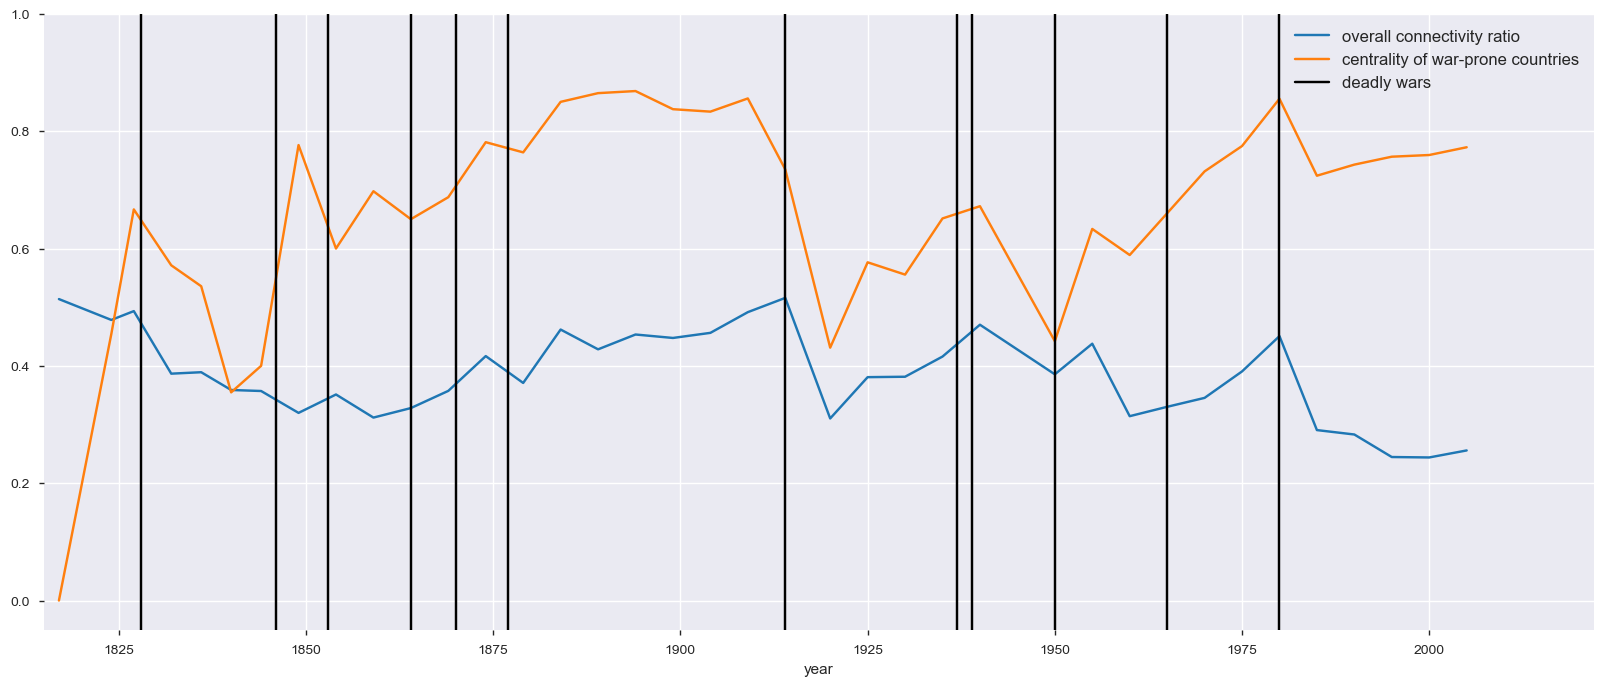

In [419]:
fig = figure(figsize=(20, 8))
de_noInterpolation['connectivity_ratio'].plot()
de_noInterpolation['warlike_centrality'].plot()
for xcoord in wars[wars['is_highDeath']==1]['StartYear1']:
    plt.axvline(x=xcoord, color = 'k')
axes = plt.gca()
axes.set_ylim([-0.05,1]) 
axes.set_xlim([1815,2022])  
plt.legend(['overall connectivity ratio', 'centrality of war-prone countries', 'deadly wars'], fontsize = 12, loc = 'best')    
plt.show()    

Eyeballing the data does not immediately lead to any insights. Let's try to do some EDA that is more formal. 

***
## Putting all data that we wrangled so far into one dataframe.

Our diplomatic relations dataframe does not contain data for each year between 1817 and 2005. But we need to merge it together with our dataset indicating the years when devastating wars started, so that we could have a cohesive story. 
> First, let's make sure each year has a row in the deadly wars dataset, and indicate which years have a deadly war coming up within the next five years.

Let's see if there were any years when more than one devastating war started.

In [420]:
deadly_wars = wars[wars['is_highDeath']==1]
deadly_wars['StartYear1'].duplicated().sum()

0

No such years: this means we are safe to make the start year into the index of the dataset.

In [421]:
deadly_wars.set_index('StartYear1', inplace = True)

In [422]:
deadly_wars = deadly_wars.reindex(list(range(1824, 2006)))
deadly_wars.head()

,WarNum,BatDeath,WorldPop,casualtiesVWorldPop,is_highDeath
StartYear1,,,,,
1824,NaN,NaN,NaN,NaN,NaN
1825,NaN,NaN,NaN,NaN,NaN
1826,NaN,NaN,NaN,NaN,NaN
1827,NaN,NaN,NaN,NaN,NaN
1828,4.0,130000.0,108695652.0,0.001196,1.0


Let's have our last column indicate if a devastating war is going to happen within 5 years: `is_HighDeathInNxt5Yrs`.

In [423]:
wars_interpolated = deadly_wars.copy()
list_cols = [c for c in deadly_wars.columns[:-1]]
list_cols.append('is_HighDeathInNxt5Yrs')
wars_interpolated.columns = list_cols
wars_interpolated.head()

,WarNum,BatDeath,WorldPop,casualtiesVWorldPop,is_HighDeathInNxt5Yrs
StartYear1,,,,,
1824,NaN,NaN,NaN,NaN,NaN
1825,NaN,NaN,NaN,NaN,NaN
1826,NaN,NaN,NaN,NaN,NaN
1827,NaN,NaN,NaN,NaN,NaN
1828,4.0,130000.0,108695652.0,0.001196,1.0


In [425]:
for i in wars_interpolated[wars_interpolated['is_HighDeathInNxt5Yrs']==1].index:
    if (i-1) in(wars_interpolated.index): wars_interpolated.loc[i-1, 'is_HighDeathInNxt5Yrs'] = 1
    if (i-2) in(wars_interpolated.index): wars_interpolated.loc[i-2, 'is_HighDeathInNxt5Yrs'] = 1
    if (i-3) in(wars_interpolated.index): wars_interpolated.loc[i-3, 'is_HighDeathInNxt5Yrs'] = 1
    if (i-4) in(wars_interpolated.index): wars_interpolated.loc[i-4, 'is_HighDeathInNxt5Yrs'] = 1
wars_interpolated.head(15)    

,WarNum,BatDeath,WorldPop,casualtiesVWorldPop,is_HighDeathInNxt5Yrs
StartYear1,,,,,
1824,NaN,NaN,NaN,NaN,1.0
1825,NaN,NaN,NaN,NaN,1.0
1826,NaN,NaN,NaN,NaN,1.0
1827,NaN,NaN,NaN,NaN,1.0
1828,4.0,130000.0,108695652.0,0.001196,1.0
1829,NaN,NaN,NaN,NaN,NaN
1830,NaN,NaN,NaN,NaN,NaN
1831,NaN,NaN,NaN,NaN,NaN
1832,NaN,NaN,NaN,NaN,NaN


All other years' `is_HighDeathInNxt5Yrs` values will be set to zero.

In [426]:
wars_interpolated.fillna({'is_HighDeathInNxt5Yrs':0}, inplace=True)
wars_interpolated.head(10)

,WarNum,BatDeath,WorldPop,casualtiesVWorldPop,is_HighDeathInNxt5Yrs
StartYear1,,,,,
1824,NaN,NaN,NaN,NaN,1.0
1825,NaN,NaN,NaN,NaN,1.0
1826,NaN,NaN,NaN,NaN,1.0
1827,NaN,NaN,NaN,NaN,1.0
1828,4.0,130000.0,108695652.0,0.001196,1.0
1829,NaN,NaN,NaN,NaN,0.0
1830,NaN,NaN,NaN,NaN,0.0
1831,NaN,NaN,NaN,NaN,0.0
1832,NaN,NaN,NaN,NaN,0.0


We can finally merge our wars dataset and our diplomatic exchange dataset!

In [427]:
de_df = de_noInterpolation.join(wars_interpolated, how ='left')
de_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 1817 to 2005
Data columns (total 11 columns):
numCountries             38 non-null int64
numConns                 38 non-null int64
connectivity_ratio       38 non-null float64
warlike_c_conns          38 non-null int64
warlike_numCountries     38 non-null int64
warlike_centrality       38 non-null float64
WarNum                   5 non-null float64
BatDeath                 5 non-null float64
WorldPop                 5 non-null float64
casualtiesVWorldPop      5 non-null float64
is_HighDeathInNxt5Yrs    37 non-null float64
dtypes: float64(7), int64(4)
memory usage: 4.8 KB


In [428]:
de_df[de_df['is_HighDeathInNxt5Yrs'].isna()]

,numCountries,numConns,connectivity_ratio,warlike_c_conns,warlike_numCountries,warlike_centrality,WarNum,BatDeath,WorldPop,casualtiesVWorldPop,is_HighDeathInNxt5Yrs
year,,,,,,,,,,,
1817,23,260,0.513834,0,0,0.0,NaN,NaN,NaN,NaN,NaN


In [429]:
de_df.loc[1817, 'is_HighDeathInNxt5Yrs'] = 0

***
## A quick preliminary analysis: time series.

Let's see if degree centrality of war-prone countries is cointegrated with the likelihood of devastating war.

In [430]:
# Import the statsmodels module for regression and the Adfuller function
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Regress likelihood of war in the next 5 years on war-prone countries' centrality
warlike_centrality = sm.add_constant(de_df[['warlike_centrality']])
likelihood_of_war = de_df[['is_HighDeathInNxt5Yrs']]                                            

In [431]:
result = sm.OLS(likelihood_of_war, warlike_centrality).fit()

# Compute ADF
b = result.params[1]
print(b)

-0.1473096805466749


In [432]:
adf_stats = adfuller(warlike_centrality['warlike_centrality'] - b*likelihood_of_war['is_HighDeathInNxt5Yrs'])
print("The p-value for the ADF test is ", adf_stats[1])

The p-value for the ADF test is  3.1102602429667035e-07


## We see that degree centrality of the top countries that have historically been prone to go into international wars, is cointegrated with the likelihood that a deadly war will occur in the next 5 years.